# CS_BP预处理部分

In [35]:
import numpy as np
import scipy.special as sc_special
import tensorflow as tf 
from 	tensorflow import keras
import pandas as pd
from tensorflow.keras import optimizers,metrics,layers,Sequential

In [36]:
# 导入数据以及预处理
data = pd.read_csv('DATASETS/EnvData.csv',sep=',',header=None,usecols=[0,1,2,3])
X = data.iloc[:801,:3]
Y = data.iloc[:801,3]
TestX = data.iloc[801:,:3]
TestY = data.iloc[801:,3]

inputnum = 3
hiddennum = 8
outputnum = 2
numsum = inputnum*hiddennum+hiddennum+hiddennum*outputnum+outputnum #6*10+10+10*3+3=103
bestfit = []
bestloss = []

def preprocess(x,y):
    x = tf.cast(x,dtype=tf.float32) 
    y = tf.cast(y,dtype=tf.int32)
    y = tf.one_hot(y,depth=2)
    return x,y

In [37]:
#数据预处理
#零均值处理
X[0] -= np.mean(X,axis=0)[0]  
X[1] -= np.mean(X,axis=0)[1]
X[2] -= np.mean(X,axis=0)[2]
#归一化
X[0] /= np.max(np.abs(X),axis=0)[0]
X[1] /= np.max(np.abs(X),axis=0)[1]
X[2] /= np.max(np.abs(X),axis=0)[2]

In [38]:
#零均值处理
TestX[0] -= np.mean(TestX,axis=0)[0]  
TestX[1] -= np.mean(TestX,axis=0)[1]
TestX[2] -= np.mean(TestX,axis=0)[2]
#归一化
TestX[0] /= np.max(np.abs(TestX),axis=0)[0]
TestX[1] /= np.max(np.abs(TestX),axis=0)[1]
TestX[2] /= np.max(np.abs(TestX),axis=0)[2]


In [39]:
batchsz = 16
db = tf.data.Dataset.from_tensor_slices((X,Y))
db = db.map(preprocess).shuffle(60000).batch(batchsz)
ds_val = tf.data.Dataset.from_tensor_slices((TestX,TestY))
ds_val = ds_val.map(preprocess).batch(batchsz)
sample = next(iter(db))
print(sample[0].shape,sample[1].shape)
copyX = X
Y_onehot = tf.one_hot(Y,depth=2)
TestY_onehot = tf.one_hot(TestY,depth=2)
X = tf.cast(X,dtype=tf.float32) 
TestX = tf.cast(TestX,dtype=tf.float32) 

(16, 3) (16, 2)


# CS部分

In [8]:

#n：布谷鸟数  m：布谷鸟的维度
def cuckoo_search(n, m, lower_boundary, upper_boundary, iter_num = 2,pa = 0.25, beta = 1.5, step_size = 0.1):
    """
    Cuckoo search function
    ---------------------------------------------------
    Input parameters:
        n: Number of nests
        m: Number of dimensions
        fit_func: User defined fitness evaluative function
        lower_boundary: Lower bounary (example: lower_boundary = (-2, -2, -2))
        upper_boundary: Upper boundary (example: upper_boundary = (2, 2, 2))
        iter_num: Number of iterations (default: 100) 
        pa: Possibility that hosts find cuckoos' eggs (default: 0.25)
        beta: Power law index (note: 1 < beta < 2) (default: 1.5)
        step_size:  Step size scaling factor related to the problem's scale (default: 0.1)
    Output:
        The best solution and its value
    """
    # get initial nests' locations 
    nests = generate_nests(n, m, lower_boundary, upper_boundary)
    fitness,lossness = calc_fitness( nests,0.5) #包含所有的适应度  用列表存储
    
    #得到每代最小loss
    best_loss_index = np.argmin(lossness)
    best_loss = lossness[best_loss_index]
    best_nestloss = nests[best_loss_index].copy()
    bestloss.append(best_loss)
    
    # get the best nest and record it
    best_nest_index = np.argmax(fitness)
    best_fitness = fitness[best_nest_index]
    best_nest = nests[best_nest_index].copy()
    bestfit.append(best_fitness) #全局变量，保存每代最佳适应度值
    
    best_two_nest = best_nest
    best_two_loss = best_loss
    best_two_fitness = fitness[best_nest_index]
    print('\r\n BEST_TWO_LOSSNESS IS %.2f : \r\n',best_two_loss)
    print('\r\n BEST_TWO_FITNESS IS %.2f : \r\n',best_two_fitness)
    for _ in range(iter_num):
        nests = update_nests(lower_boundary, upper_boundary, nests, best_nest, fitness, step_size,best_fitness)
        nests = abandon_nests(nests, lower_boundary, upper_boundary, pa)
        print('\r\n*******************************************************一轮迭代后开始计算适应度*************************************************************\r\n')
        fitness,lossness = calc_fitness( nests,best_fitness)
        print('\r\n*****************************************************************结束************************************************************\r\n')
        max_nest_index = np.argmax(fitness)
        max_fitness = fitness[max_nest_index]
        max_nest = nests[max_nest_index]
        bestfit.append(max_fitness)
        
        min_loss_index = np.argmin(lossness)
        min_loss = lossness[min_loss_index]
        min_loss_fit = fitness[min_loss_index]
        min_nestloss = nests[min_loss_index]
        bestloss.append(min_loss)
            
        if min_loss < best_two_loss  : #and  min_loss_fit > best_two_fitness
            best_two_nest = min_nestloss
            best_two_loss = min_loss
            best_two_fitness = min_loss_fit
            print('\r\n******')
            print('\r\n BEST_TWO_FITNESS IS %.2f : \r\n',best_two_fitness)
            print('\r\n BEST_TWO_LOSSNESS IS %.2f : \r\n',best_two_loss)
            print('\r\n******\r\n')
            

    return (best_two_nest, best_two_loss,best_two_fitness)

In [9]:
def generate_nests(n, m, lower_boundary, upper_boundary):
    """
    Generate the nests' locations
    ---------------------------------------------------
    Input parameters:
        n: Number of nests
        m: Number of dimensions
        lower_boundary: Lower bounary (example: lower_boundary = (-2, -2, -2))
        upper_boundary: Upper boundary (example: upper_boundary = (2, 2, 2))
    Output:
        generated nests' locations
    """
    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    nests = np.empty((n, m))

    for each_nest in range(n):
        nests[each_nest] = lower_boundary + np.array([np.random.rand() for _ in range(m)]) * (upper_boundary - lower_boundary)

    return nests

In [10]:
def update_nests(lower_boundary, upper_boundary, nests, best_nest, fitness, step_coefficient,bestfitness):
    """
    This function is to get new nests' locations and use new better one to replace the old nest
    ---------------------------------------------------
    Input parameters:
        fit_func: User defined fitness evaluative function
        lower_boundary: Lower bounary (example: lower_boundary = (-2, -2, -2))
        upper_boundary: Upper boundary (example: upper_boundary = (2, 2, 2))
        nests: Old nests' locations 
        best_nest: Nest with best fitness
        fitness: Every nest's fitness
        step_coefficient:  Step size scaling factor related to the problem's scale (default: 0.1)
    Output:
        Updated nests' locations
    """
    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    # 莱维飞行生成步长：较长时间的短步长和较短时间的长步长
    #生成的步长的shape也是n*m，保证所有元素得到更新
    #这个步长通过step_size来控制大小
    steps = levy_flight(n, m, 1.5)
    new_nests = nests.copy()

    for each_nest in range(n):
        # coefficient 0.01 is to avoid levy flights becoming too aggresive
        # and (nest[each_nest] - best_nest) 保留了最佳nest，但会导致局部最优
        step_size = step_coefficient * steps[each_nest] * (nests[each_nest] - best_nest)
        step_direction = np.random.rand(m) #0-1均匀概率分布生成方向
        #新的布谷鸟在原来的基础上加上步长和方向
        new_nests[each_nest] += step_size * step_direction  
        # apply boundary condtions
        new_nests[each_nest][new_nests[each_nest] < lower_boundary] = lower_boundary[new_nests[each_nest] < lower_boundary]
        new_nests[each_nest][new_nests[each_nest] > upper_boundary] = upper_boundary[new_nests[each_nest] > upper_boundary]

    new_fitness,new_losses = calc_fitness(new_nests,bestfitness)
    #适应度更好的才更新过去
    nests[new_fitness > fitness] = new_nests[new_fitness > fitness] 
    
    return nests

In [11]:
def abandon_nests(nests, lower_boundary, upper_boundary, pa):
    """
    Some cuckoos' eggs are found by hosts, and are abandoned.So cuckoos need to find new nests.
    ---------------------------------------------------
    Input parameters:
        nests: Current nests' locations
        lower_boundary: Lower bounary (example: lower_boundary = (-2, -2, -2))
        upper_boundary: Upper boundary (example: upper_boundary = (2, 2, 2))
        pa: Possibility that hosts find cuckoos' eggs
    Output:
        Updated nests' locations
    """
    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    for each_nest in range(n):  
        #pa概率抛弃，抛弃后重新生成
        if (np.random.rand() < pa):
            #局部随机行走生成步长
            #随机两个种群相差*一个0-1的随机数
            step_size = np.random.rand() * (nests[np.random.randint(0, n)] - nests[np.random.randint(0, n)])
            nests[each_nest] += step_size
            # apply boundary condtions
            nests[each_nest][nests[each_nest] < lower_boundary] = lower_boundary[nests[each_nest] < lower_boundary]
            nests[each_nest][nests[each_nest] > upper_boundary] = upper_boundary[nests[each_nest] > upper_boundary]
    
    return nests

In [12]:
def levy_flight(n, m, beta):
    """
    This function implements Levy's flight.
    ---------------------------------------------------
    Input parameters:
        n: Number of steps 
        m: Number of dimensions
        beta: Power law index (note: 1 < beta < 2)
    Output:
        'n' levy steps in 'm' dimension
    """
    sigma_u = (sc_special.gamma(1+beta)*np.sin(np.pi*beta/2)/(sc_special.gamma((1+beta)/2)*beta*(2**((beta-1)/2))))**(1/beta)
    sigma_v = 1

    u =  np.random.normal(0, sigma_u, (n, m))
    v = np.random.normal(0, sigma_v, (n, m))

    steps = u/((np.abs(v))**(1/beta))

    return steps

In [13]:
def calc_fitness(nests,bestfitness):
    
    n, m = nests.shape
    fitness = np.empty(n)
    lossness = np.empty(n)
    for Sig_nest in range(n):
        chrom = nests[Sig_nest]
        #分解模型参数
        w1 = chrom[:inputnum*hiddennum]
        w1 = w1.reshape(inputnum,hiddennum)
        b1 = chrom[inputnum*hiddennum:inputnum*hiddennum+hiddennum]
        w2 = chrom[inputnum*hiddennum+hiddennum:inputnum*hiddennum+hiddennum+hiddennum*outputnum]
        w2 = w2.reshape(hiddennum,outputnum)
        b2 = chrom[inputnum*hiddennum+hiddennum+hiddennum*outputnum:]

        WB_l1 = (w1,b1)
        WB_l2 = (w2,b2)
        #创建模型，并赋予参数
        model = keras.Sequential([
            keras.layers.Dense(hiddennum,activation='relu',name='l1'),
            keras.layers.Dense(outputnum,name='l2')
        ])
        model.build(input_shape=[None,inputnum])
        
        #model.summary()
        model.compile(optimizer=optimizers.Adam(lr=0.01),
                    loss='mse',
                    metrics=['accuracy'])
        
        layer1 = model.get_layer('l1')
        layer2 = model.get_layer('l2')
        layer1.set_weights(WB_l1)
        layer2.set_weights(WB_l2)
        
        #训练模型
        #model.fit(db,epochs=1,validation_data=ds_val,validation_freq=1)
        model.fit(db,epochs=1)
        loss,acc = model.evaluate(db)  #这里是用验证集评估，其实应该用测试集吧 evaluate产生两个结果，前面是损失，后面是准确率
        lossness[Sig_nest] = loss
        fitness[Sig_nest] = acc  #将模型评估正确率作为适应度返回
        
        if(acc>bestfitness): #在计算适应度的过程当中，发现有更好的适应度就把参数保存
            #model.save_weights('my_model_fun.h5')
            bestfitness = acc
    return fitness,lossness

In [14]:
# if __name__=='__main__':
low = -3*np.ones(numsum)
upp = 3*np.ones(numsum)
best_nestloss, best_loss,fit = cuckoo_search(5,numsum, low,upp, step_size = 0.1)
best_nest = best_nestloss
best_fitness = best_loss
print('CS最优loss为:%.5f!',best_loss),print('CS最优fit为：%.5f!',fit)



51/51 [==============================] - 0s 939us/step - loss: 1.9419 - accuracy: 0.5056

 BEST_TWO_LOSSNESS IS %.2f : 
 1.9418995380401611

 BEST_TWO_FITNESS IS %.2f : 
 0.6604244709014893
51/51 [==============================] - 0s 1ms/step - loss: 3.7426 - accuracy: 0.6092

*******************************************************一轮迭代后开始计算适应度*************************************************************

51/51 [==============================] - 0s 979us/step - loss: 0.7381 - accuracy: 0.6454

*****************************************************************结束************************************************************


******

 BEST_TWO_FITNESS IS %.2f : 
 0.6454432010650635

 BEST_TWO_LOSSNESS IS %.2f : 
 0.7381342649459839

******

51/51 [==============================] - 0s 1ms/step - loss: 0.6705 - accuracy: 0.6442

*******************************************************一轮迭代后开始计算适应度*************************************************************

51/51 [==============================

(None, None)

# 神经网络部分

In [16]:
chrom = best_nest
w1 = chrom[:inputnum*hiddennum]
w1 = w1.reshape(inputnum,hiddennum)
b1 = chrom[inputnum*hiddennum:inputnum*hiddennum+hiddennum]
w2 = chrom[inputnum*hiddennum+hiddennum:inputnum*hiddennum+hiddennum+hiddennum*outputnum]
w2 = w2.reshape(hiddennum,outputnum)
b2 = chrom[inputnum*hiddennum+hiddennum+hiddennum*outputnum:]

WB_layer1 = (w1,b1)
WB_layer2 = (w2,b2)

In [41]:
#用CS优化初始化阈值

model = keras.Sequential([
    keras.layers.Dense(hiddennum,name='layer1',activation='relu'),
    keras.layers.Dense(outputnum,name='layer2')
])


model.build(input_shape=[None,inputnum])
#model.summary()
model.compile(optimizer=optimizers.Adam(lr=0.01),
            loss='mse',
            metrics=['accuracy'])
#model.load_weights('my_model_fun.h5')
#训练模型
model.fit(db,epochs=500,validation_data=ds_val,validation_freq=5)

# layer1 = model.get_layer('layer1')
# layer2 = model.get_layer('layer2')
# layer1.set_weights(WB_layer1)
# layer2.set_weights(WB_layer2)

Epoch 1/500
51/51 [==============================] - 1s 1ms/step - loss: 0.3495 - accuracy: 0.6047
Epoch 2/500
51/51 [==============================] - 0s 1ms/step - loss: 0.1785 - accuracy: 0.7958
Epoch 3/500
51/51 [==============================] - 0s 1ms/step - loss: 0.1606 - accuracy: 0.8231
Epoch 4/500
51/51 [==============================] - 0s 1ms/step - loss: 0.1420 - accuracy: 0.8578
Epoch 5/500
51/51 [==============================] - 0s 7ms/step - loss: 0.1390 - accuracy: 0.8639 - val_loss: 0.1201 - val_accuracy: 0.8980
Epoch 6/500
51/51 [==============================] - 0s 1ms/step - loss: 0.1188 - accuracy: 0.9015
Epoch 7/500
51/51 [==============================] - 0s 1ms/step - loss: 0.1313 - accuracy: 0.8643
Epoch 8/500
51/51 [==============================] - 0s 1ms/step - loss: 0.1082 - accuracy: 0.9008
Epoch 9/500
51/51 [==============================] - 0s 1ms/step - loss: 0.1157 - accuracy: 0.8709
Epoch 10/500
51/51 [==============================] - 0s 3ms/step -

51/51 [==============================] - 0s 2ms/step - loss: 0.0924 - accuracy: 0.8952
Epoch 77/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0745 - accuracy: 0.9101
Epoch 78/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.9349
Epoch 79/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0767 - accuracy: 0.9298
Epoch 80/500
51/51 [==============================] - 0s 3ms/step - loss: 0.0757 - accuracy: 0.9361 - val_loss: 0.0711 - val_accuracy: 0.9388
Epoch 81/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0739 - accuracy: 0.9170
Epoch 82/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0729 - accuracy: 0.9220
Epoch 83/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0717 - accuracy: 0.9368
Epoch 84/500
51/51 [==============================] - 0s 999us/step - loss: 0.0725 - accuracy: 0.9286
Epoch 85/500
51/51 [==============================] - 0s 4ms/step - l

Epoch 151/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0674 - accuracy: 0.9320
Epoch 152/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0689 - accuracy: 0.9324
Epoch 153/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0724 - accuracy: 0.9350
Epoch 154/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0770 - accuracy: 0.9284
Epoch 155/500
51/51 [==============================] - 0s 3ms/step - loss: 0.0741 - accuracy: 0.9341 - val_loss: 0.0706 - val_accuracy: 0.9184
Epoch 156/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0687 - accuracy: 0.9350
Epoch 157/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0730 - accuracy: 0.9334
Epoch 158/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0671 - accuracy: 0.9370
Epoch 159/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0760 - accuracy: 0.9171
Epoch 160/500
51/51 [============================

Epoch 226/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0712 - accuracy: 0.9397
Epoch 227/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0693 - accuracy: 0.9332
Epoch 228/500
51/51 [==============================] - 0s 959us/step - loss: 0.0818 - accuracy: 0.9216
Epoch 229/500
51/51 [==============================] - 0s 939us/step - loss: 0.0698 - accuracy: 0.9352
Epoch 230/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0734 - accuracy: 0.9363 - val_loss: 0.0729 - val_accuracy: 0.9388
Epoch 231/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0628 - accuracy: 0.9379
Epoch 232/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0613 - accuracy: 0.9414
Epoch 233/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0742 - accuracy: 0.9215
Epoch 234/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0726 - accuracy: 0.9176
Epoch 235/500
51/51 [========================

Epoch 301/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0698 - accuracy: 0.9240
Epoch 302/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0741 - accuracy: 0.9251
Epoch 303/500
51/51 [==============================] - 0s 999us/step - loss: 0.0672 - accuracy: 0.9257
Epoch 304/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0621 - accuracy: 0.9468
Epoch 305/500
51/51 [==============================] - 0s 3ms/step - loss: 0.0644 - accuracy: 0.9424 - val_loss: 0.0710 - val_accuracy: 0.9184
Epoch 306/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0676 - accuracy: 0.9313
Epoch 307/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0697 - accuracy: 0.9254
Epoch 308/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0761 - accuracy: 0.9305
Epoch 309/500
51/51 [==============================] - 0s 920us/step - loss: 0.0628 - accuracy: 0.9489
Epoch 310/500
51/51 [========================

51/51 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9342 - val_loss: 0.0723 - val_accuracy: 0.9388
Epoch 376/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0702 - accuracy: 0.9299
Epoch 377/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0683 - accuracy: 0.9401
Epoch 378/500
51/51 [==============================] - 0s 999us/step - loss: 0.0623 - accuracy: 0.9395
Epoch 379/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0648 - accuracy: 0.9374
Epoch 380/500
51/51 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 0.9426 - val_loss: 0.0970 - val_accuracy: 0.9592
Epoch 381/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0606 - accuracy: 0.9458
Epoch 382/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0676 - accuracy: 0.9384
Epoch 383/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.9282
Epoch 384/500
51/51

51/51 [==============================] - 0s 1ms/step - loss: 0.0679 - accuracy: 0.9337
Epoch 450/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0693 - accuracy: 0.9277 - val_loss: 0.0710 - val_accuracy: 0.9388
Epoch 451/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0697 - accuracy: 0.9216
Epoch 452/500
51/51 [==============================] - 0s 978us/step - loss: 0.0790 - accuracy: 0.9299
Epoch 453/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0754 - accuracy: 0.9355
Epoch 454/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0686 - accuracy: 0.9345
Epoch 455/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0595 - accuracy: 0.9447 - val_loss: 0.0725 - val_accuracy: 0.9184
Epoch 456/500
51/51 [==============================] - 0s 1ms/step - loss: 0.0653 - accuracy: 0.9421
Epoch 457/500
51/51 [==============================] - 0s 2ms/step - loss: 0.0643 - accuracy: 0.9525
Epoch 458/500
51/51

In [18]:
#查看模型参数
la1 = model.get_layer('layer1')
la2 = model.get_layer('layer2')
(k1,b1) = la1.get_weights()
(k2,b2) = la2.get_weights()
k1,b1,k2,b2

(array([[ 1.4875704 , -1.8567637 ,  2.1771398 , -2.061858  ,  0.00475263,
          2.4660892 ,  1.4634211 ,  0.32650545],
        [-0.4929458 , -1.4671715 , -1.858962  , -0.8773004 , -1.4339482 ,
         -0.16887647, -1.0841436 , -2.121088  ],
        [-0.79854053, -0.1634232 , -1.8358492 , -0.24242344,  1.109231  ,
          0.10794401, -0.48483464, -0.72820514]], dtype=float32),
 array([ 1.2582238, -2.0323274, -2.2291923, -2.3687668,  1.2368942,
        -0.5347749, -1.6295109, -0.558057 ], dtype=float32),
 array([[-1.2160908 ,  0.05823324],
        [ 1.1308508 ,  1.8576275 ],
        [-1.9796593 ,  0.6110159 ],
        [ 0.5758099 ,  0.53625387],
        [ 2.6233857 ,  1.773005  ],
        [-0.35329446, -0.95336735],
        [-2.527787  ,  1.6016471 ],
        [-1.5767891 ,  0.25695062]], dtype=float32),
 array([ 1.9622333, -1.042854 ], dtype=float32))

In [19]:
#训练模型
model.fit(db,epochs=100,validation_data=ds_val,validation_freq=5)



Epoch 1/100
51/51 [==============================] - 1s 1ms/step - loss: 3.4766 - accuracy: 0.4714
Epoch 2/100
51/51 [==============================] - 0s 1ms/step - loss: 0.6660 - accuracy: 0.3922
Epoch 3/100
51/51 [==============================] - 0s 1ms/step - loss: 0.3978 - accuracy: 0.4752
Epoch 4/100
51/51 [==============================] - 0s 1ms/step - loss: 0.3077 - accuracy: 0.5848
Epoch 5/100
51/51 [==============================] - 0s 5ms/step - loss: 0.2644 - accuracy: 0.6507 - val_loss: 0.2371 - val_accuracy: 0.6939
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.2337 - accuracy: 0.7711
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.2185 - accuracy: 0.7217
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.1985 - accuracy: 0.7408
Epoch 9/100
51/51 [==============================] - 0s 1ms/step - loss: 0.1985 - accuracy: 0.7442
Epoch 10/100
51/51 [==============================] - 0s 2ms/step -

51/51 [==============================] - 0s 1ms/step - loss: 0.1234 - accuracy: 0.8503
Epoch 77/100
51/51 [==============================] - 0s 899us/step - loss: 0.1238 - accuracy: 0.8409
Epoch 78/100
51/51 [==============================] - 0s 999us/step - loss: 0.1365 - accuracy: 0.8291
Epoch 79/100
51/51 [==============================] - 0s 1ms/step - loss: 0.1208 - accuracy: 0.8537
Epoch 80/100
51/51 [==============================] - 0s 7ms/step - loss: 0.1363 - accuracy: 0.8246 - val_loss: 0.1243 - val_accuracy: 0.8367
Epoch 81/100
51/51 [==============================] - 0s 959us/step - loss: 0.1223 - accuracy: 0.8516
Epoch 82/100
51/51 [==============================] - 0s 940us/step - loss: 0.1360 - accuracy: 0.8333
Epoch 83/100
51/51 [==============================] - 0s 1ms/step - loss: 0.1417 - accuracy: 0.8034
Epoch 84/100
51/51 [==============================] - 0s 1ms/step - loss: 0.1350 - accuracy: 0.8261
Epoch 85/100
51/51 [==============================] - 0s 3ms/st

In [52]:
# 评估模型,不输出预测结果
loss,accuracy = model.evaluate(ds_val)
print('\ntest loss',loss)
print('accuracy',accuracy)

4/4 [==============================] - 0s 2ms/step - loss: 0.0952 - accuracy: 0.9184

test loss 0.09522389620542526
accuracy 0.918367326259613


In [34]:
y_pred = model.predict(TestX)
y_pred

array([[ 0.1779846 ,  0.8479603 ],
       [ 0.8649198 ,  0.15356797],
       [ 0.32143128,  0.7386407 ],
       [ 0.6956669 ,  0.2750966 ],
       [ 0.35711765,  0.6819511 ],
       [-0.02068806,  1.0091612 ],
       [ 0.6122236 ,  0.3618161 ],
       [ 0.2014364 ,  0.78227836],
       [ 0.63400066,  0.38282996],
       [ 0.33712375,  0.69185835],
       [ 0.49212712,  0.5728453 ],
       [ 0.71215606,  0.24951822],
       [ 0.9980166 ,  0.04948068],
       [ 1.3983151 , -0.33317196],
       [ 1.0024089 , -0.02815598],
       [ 1.04518   , -0.09454542],
       [ 0.42661107,  0.62209266],
       [ 0.72485745,  0.27702373],
       [ 0.90431654,  0.15034223],
       [ 0.40744328,  0.61687297],
       [ 0.0781585 ,  0.9507883 ],
       [ 0.9695314 , -0.00616938],
       [ 0.4542104 ,  0.5615484 ],
       [ 1.0835104 , -0.03831428],
       [ 0.39017868,  0.6264654 ],
       [ 0.3473953 ,  0.6419485 ],
       [ 0.5482373 ,  0.4456609 ],
       [ 0.38692677,  0.64399034],
       [ 0.22121286,

In [42]:
#模型预测,输入测试集,输出预测结果
y_pred = model.predict(TestX)
y_pred = tf.argmax(y_pred,axis=1)
y_pred

<tf.Tensor: shape=(49,), dtype=int64, numpy=
array([1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1], dtype=int64)>

In [43]:
test_y = tf.argmax(TestY_onehot,axis=1)
test_y

<tf.Tensor: shape=(49,), dtype=int64, numpy=
array([1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1], dtype=int64)>

In [44]:
y_pred_train = model.predict(X)
y_pred_train = tf.argmax(y_pred_train,axis=1)


In [45]:
train_y = tf.argmax(Y_onehot,axis=1)


# 绘图部分

In [46]:
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

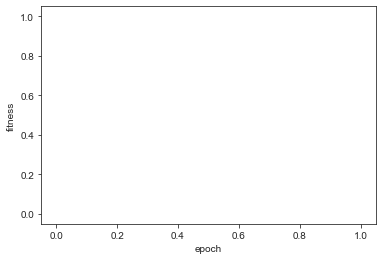

In [47]:
sns.set_style("ticks")
x = list(range(0,len(bestfit)))
fig = sns.lineplot(x,bestfit)
plt.xlabel("epoch")
plt.ylabel("fitness")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./BestFit', dpi = 400)

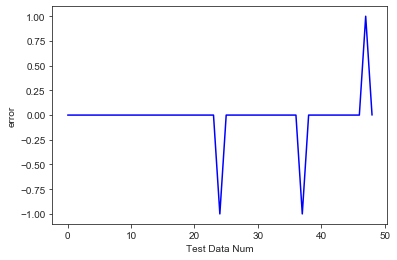

In [48]:
error = y_pred - test_y
x = list(range(0,len(error)))
fig = sns.lineplot(x,error,color="b")
plt.xlabel("Test Data Num")
plt.ylabel("error")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./Error_Num', dpi = 400)


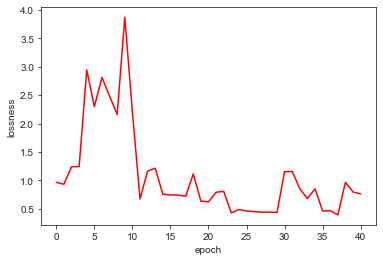

In [70]:
x = list(range(0,len(bestfit)))
fig = sns.lineplot(x,bestloss,color="r")
plt.xlabel("epoch")
plt.ylabel("lossness")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./BestLoss', dpi = 400)

In [ ]:
#sns主题风格  darkgrid  whitegrid  dark  white  ticks
sns.set_style("ticks")  #设置主题风格
sns.color_palette("hls",8)  #设置颜色空间种类（几种可用颜色）
data=np.random.normal(size=(20,8)) + np.arange(8) /2
sns.boxplot(data = data,palette = sns.color_palette("hls",8))

# 描述两个变量的关系 最好用散点图

In [ ]:
import pandas as pd
mean,cov = [0,1],[(1,.5),(.5,1)]
data = np.random.multivariate_normal(mean,cov,200)
df = pd.DataFrame(data,columns=["x","y"])
#绘制散点图
sns.jointplot(x="x",y="y",data = df,color="r")  #如果点很多，用颜色深度表示数量 kind="hex" ,可以单独传x y

# 移植STM32准备

In [30]:
Testx = X / X.max().max()
Testx = np.array(Testx)

In [2]:
aa = []
aa.append(list(Testx[0]))
aa

NameError: name 'Testx' is not defined

In [32]:
pre_sig=model.predict(aa)
pre_sig

array([[0.3447314, 0.6587833]], dtype=float32)

In [33]:
index = np.argmax(pre_sig,axis=None)
index

1

In [34]:
Y

0      1
1      1
2      0
3      1
4      0
      ..
796    0
797    1
798    0
799    0
800    1
Name: 0, Length: 801, dtype: int64

# 模型保存

In [87]:
model.save('Env.h5')

In [36]:
converter = tf.lite.TFLiteConverter.from_keras_model(load_model)
tflite_model = converter.convert()
open("Env.tflite", "wb").write(tflite_model)

NameError: name 'load_model' is not defined

In [ ]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D
from tensorflow.keras import Sequential
import tensorflow.keras as keras
import numpy as np

In [ ]:


# #建立一个测试模型
model = Sequential([
    Dense(4, input_shape=(5,), name='dense_xiaoming',
          kernel_initializer='zeros',  # 全部初始化为0
          bias_initializer='ones'),  # 全部初始化为1
])



In [ ]:
x = np.ones(shape=(8, 5))  # 创建测试数据
y = model(x)
layer = model.get_layer('dense_xiaoming')  # 通过层的名字得到层
(k, b) = layer.get_weights()  # 查看层的初始化权重值和偏置项
print(k)
print(b)

In [ ]:
layer